# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [1]:
''' Linear Algebra '''
import pandas as pd
import numpy as np
pd.set_option("max_columns",None)

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
''' Hnadling timestamps'''
import datetime
from datetime import datetime

In [3]:
# tech stocks
coin = ['BTC', 'ETH']

In [4]:
# today
end = datetime.now()

In [5]:
start = datetime(2012, 1, 1)
start

datetime.datetime(2012, 1, 1, 0, 0)

In [6]:
url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'

data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [7]:
coin_selection = "BTC"
# coin_data = {"BTC":"BTCUSD_4hours.csv"}

# data = pd.read_csv(data_path + coin_data[coin_selection])

data = data.drop(columns="Unnamed: 0").set_index("date")
data = data[10000:]
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
date,,,,,,,,,
2016-09-11 16:00:00,622.530173,622.773815,622.393815,622.601965,0.645503,6.433792,6.434183,6.433573,6.433907
2016-09-11 20:00:00,608.858585,609.295377,608.338821,608.752830,21.064810,6.411376,6.412097,6.410514,6.411200
2016-09-12 00:00:00,604.478168,604.792618,604.236335,604.450576,3.045742,6.404364,6.404884,6.403964,6.404318
2016-09-12 04:00:00,605.892222,606.177516,605.676405,605.881569,2.487445,6.406701,6.407171,6.406345,6.406684
2016-09-12 08:00:00,605.702602,606.161735,605.157959,605.682296,5.324050,6.406387,6.407145,6.405488,6.406353
...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660


In [8]:
## add other features

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.log_close.ewm(span=t).mean()
    return data

add_ema(data)

def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi



rsi = computeRSI(data)

def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  

stoch_rsi(rsi)

def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['log_close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data

add_stoch_rsi(data)

def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down

prices = data["log_close"]

get_bollinger_bands(prices, rate=20)

def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    return data

add_bollinger(data,prices)

def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data

add_vol_roc(data)
data.head(3)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
date,,,,,,,,,,,,,,,,,,,,,,
2016-09-11 16:00:00,622.530173,622.773815,622.393815,622.601965,0.645503,6.433792,6.434183,6.433573,6.433907,6.433907,6.433907,6.433907,6.433907,6.433907,6.433907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-11 20:00:00,608.858585,609.295377,608.338821,608.752830,21.064810,6.411376,6.412097,6.410514,6.411200,6.421607,6.422117,6.421986,6.422326,6.422220,6.422347,NaN,NaN,NaN,NaN,NaN,NaN,31.633193
2016-09-12 00:00:00,604.478168,604.792618,604.236335,604.450576,3.045742,6.404364,6.404884,6.403964,6.404318,6.414859,6.415722,6.415498,6.416082,6.415898,6.416118,NaN,NaN,NaN,NaN,NaN,NaN,-0.855411


### Daily return

$ return = \frac{new - old}{old} $

In [9]:
data['4h Return'] = data['close'].pct_change()
data['4h Gradient'] = data['close'].diff()

In [10]:
data = data.dropna()

## Time-Series Visualisation

### Historical Stock Prices

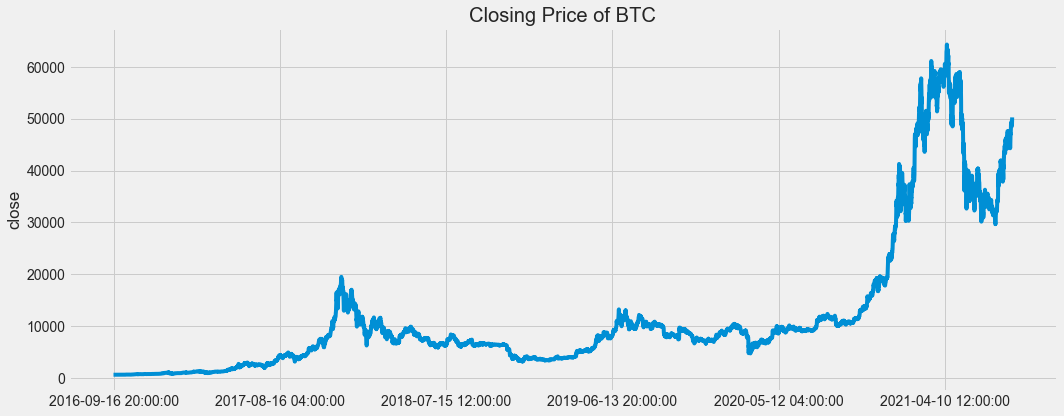

In [11]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['close'].plot()
plt.ylabel('close')
plt.xlabel(None)
plt.title(f"Closing Price of {coin_selection}")
    
plt.tight_layout()

### Volumes traded

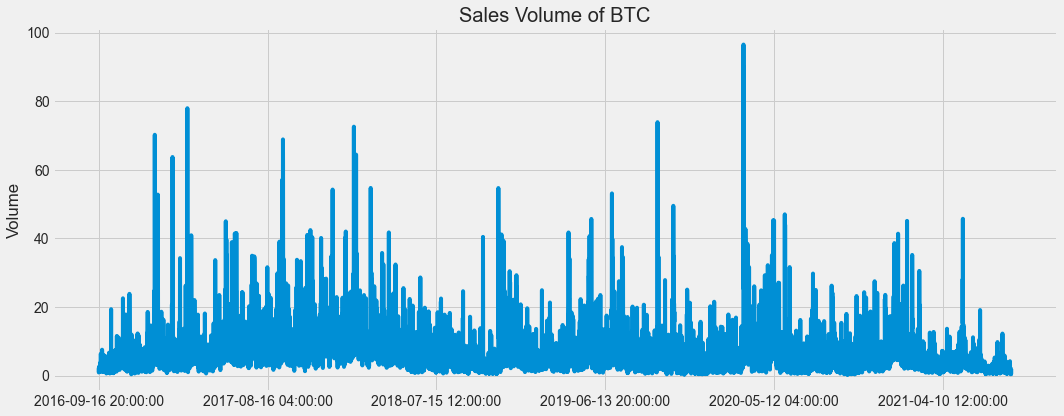

In [12]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume of BTC")
    
plt.tight_layout()

In [13]:
data.head()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc,4h Return,4h Gradient
date,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-16 20:00:00,606.420076,606.511450,606.326031,606.412748,2.307185,6.407572,6.407723,6.407417,6.407560,6.408324,6.408770,6.408638,6.409010,6.408882,6.409036,40.074263,66.832576,68.633211,6.409163,6.412655,6.405670,-0.592995,0.001020,0.618162
2016-09-17 00:00:00,606.393333,606.546449,606.200652,606.373841,0.914466,6.407528,6.407780,6.407210,6.407496,6.408196,6.408667,6.408525,6.408929,6.408790,6.408957,39.930892,54.323486,64.618565,6.409170,6.412646,6.405694,-0.603644,-0.000064,-0.038908
2016-09-17 04:00:00,605.275088,605.384737,605.165702,605.290175,0.945083,6.405683,6.405864,6.405502,6.405707,6.407812,6.408431,6.408248,6.408759,6.408586,6.408794,36.082672,52.566827,57.907630,6.408919,6.412637,6.405200,0.033480,-0.001787,-1.083665
2016-09-17 08:00:00,605.660526,605.763263,605.491368,605.612421,1.887662,6.406319,6.406488,6.406039,6.406239,6.407569,6.408257,6.408050,6.408628,6.408432,6.408667,37.996168,47.010486,51.300266,6.408753,6.412644,6.404862,0.997351,0.000532,0.322246
2016-09-17 12:00:00,605.679435,605.831129,605.474355,605.635484,1.246336,6.406350,6.406601,6.406012,6.406278,6.407370,6.408100,6.407877,6.408507,6.408293,6.408550,38.140984,42.224688,47.267334,6.408580,6.412591,6.404568,-0.339746,0.000038,0.023063


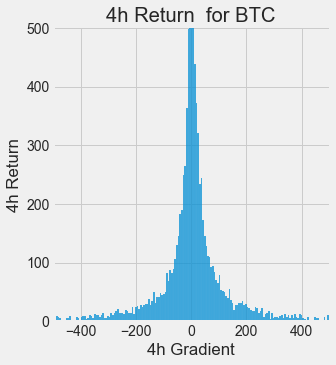

In [14]:
sns.displot(data = data, x= '4h Gradient')
plt.ylabel('4h Return')
plt.xlim([-500,500])
plt.ylim([0,500])
plt.title(f"4h Return  for {coin_selection}");

In [15]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'ema26', 'ema20', 'ema50', 'ema34',
       'ema55', 'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'vol_roc', '4h Return', '4h Gradient'],
      dtype='object')

In [80]:
selected_features = ['close','rsi','bollinger_up','4h Return']
#selected_features=['close','rsi','ema34','bollinger_up','4h Return']
#selected_features=['close','rsi','ema20','ema50','bollinger_up','4h Return']
selected_data = data[selected_features]
selected_data.sample(10)

,close,rsi,bollinger_up,4h Return
date,,,,
2016-10-07 20:00:00,613.128947,62.454881,6.419896,-0.000829
2020-08-16 20:00:00,11842.193556,56.401320,9.393221,0.000160
2020-03-02 00:00:00,8551.088667,33.082539,9.089062,0.005507
2018-04-03 12:00:00,7342.671125,58.932836,8.903788,-0.002053
2020-02-23 00:00:00,9683.822152,45.581293,9.194374,-0.000885
2020-10-19 12:00:00,11530.302750,66.959309,9.351555,0.006130
2016-12-13 00:00:00,780.082606,73.231122,6.658485,0.003285
2018-06-10 00:00:00,7472.632383,34.601824,8.955991,-0.018552
2019-05-14 12:00:00,8096.272875,81.276303,9.020613,-0.002964


##  BTC Stock Price

### Temporal Train-Test Split

In [81]:
train_percentage = 95

In [82]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

10268

In [83]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]


In [84]:
print(data_train.head(1))
print(data_train.tail(1))

                          close        rsi  bollinger_up  4h Return
date                                                               
2016-09-16 20:00:00  606.412748  40.074263      6.412655    0.00102
                            close       rsi  bollinger_up  4h Return
date                                                                
2021-05-25 00:00:00  38797.501625  54.55266     10.602687  -0.001147


## LSTM

In [85]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [86]:
minmax_scaler.data_max_

array([6.43385212e+04, 9.62292080e+01, 1.11019466e+01, 1.35906830e-01])

In [87]:
minmax_scaler.data_min_

array([ 5.94187857e+02,  4.35903634e+00,  6.39923547e+00, -1.84592994e-01])

In [88]:
min1 = minmax_scaler.data_min_[0]
min1

594.1878571428572

In [89]:
range1 = minmax_scaler.data_range_[0]
range1

63744.333309523805

### Creating subsequences...

In [90]:
window_size = 18 # test with small window size
horizon = 1 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size])

In [91]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,0].reshape(-1,1)

In [92]:
X_train.shape

(10250, 18, 4)

In [93]:
y_train.shape

(10250, 1)

In [94]:
#with the same window_size & horizon as the train data
window_size = 18
horizon = 1
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size])

In [95]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,0].reshape(-1,1)

### Baseline

In [140]:
# baseline predictions

X_test_last_seen_value = [_[-1][0] for _ in X_test]

In [152]:
X_test_last_seen_value_uns = np.array(X_test_last_seen_value) * range1 + min1

In [155]:
X_test_last_seen_value_uns = X_test_last_seen_value_uns.reshape(-1,1)

In [ ]:
y_test_unscaled = y_test * range1 + min1

In [157]:
np.mean(np.abs(y_test_unscaled - X_test_last_seen_value_uns))

368.74288851468793

### LSTM

#### RNN Architecture

In [97]:
pd.DataFrame(y_test).shape

(523, 1)

In [98]:
#from tensorflow.keras import metrics

#my_mae = metrics.MeanAbsoluteError(
    #name='mean_absolute_error', dtype=None)


In [99]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh"
                    #activation = "relu"
                     #input_shape = X_train[0].shape)
                     ))

model.add(layers.LSTM(units=64,
                      return_sequences = False,
                      activation = "relu"  
                    #activation = "relu"
                     ))

# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,
                        activation = "tanh" 
                       #activation="relu"
                      ))
#model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(8,
                       activation = "relu"
                       #activation="relu"
                      ))
model.add(layers.Dense(1,
                      activation = "relu" 
                      #activation="relu"
                      ))

#model.summary()



In [100]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [101]:
#### perhaps create a validation and train sets by hand

In [102]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, restore_best_weights=True)
#monitor = "val_mean_absolute_error"

history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    batch_size=32,
                    epochs=15,
                    verbose = 1,
                    callbacks = [es])

Epoch 1/15
257/257 [==============================] - 6s 15ms/step - loss: 1.7872e-04 - mae: 0.0072 - val_loss: 0.0145 - val_mae: 0.0805
Epoch 2/15
257/257 [==============================] - 4s 14ms/step - loss: 3.7417e-05 - mae: 0.0042 - val_loss: 0.0062 - val_mae: 0.0525
Epoch 3/15
257/257 [==============================] - 4s 14ms/step - loss: 2.7337e-05 - mae: 0.0037 - val_loss: 0.0039 - val_mae: 0.0434
Epoch 4/15
257/257 [==============================] - 4s 14ms/step - loss: 2.2113e-05 - mae: 0.0033 - val_loss: 2.7798e-04 - val_mae: 0.0106
Epoch 5/15
257/257 [==============================] - 4s 15ms/step - loss: 1.6894e-05 - mae: 0.0028 - val_loss: 2.3769e-04 - val_mae: 0.0095
Epoch 6/15
257/257 [==============================] - 4s 14ms/step - loss: 2.8937e-05 - mae: 0.0037 - val_loss: 5.9350e-04 - val_mae: 0.0192
Epoch 7/15
257/257 [==============================] - 4s 14ms/step - loss: 1.6994e-05 - mae: 0.0029 - val_loss: 7.0941e-04 - val_mae: 0.0171
Epoch 8/15
257/257 [=====

In [39]:
#def plot_loss_mae(history):
    
    #fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    #ax[0].plot(history.history['loss'])
    #ax[0].plot(history.history['val_loss'])
    #ax[0].set_title('Model loss')
    #ax[0].set_xlabel('Epoch')
    #ax[0].set_ylabel('Loss')
    #ax[0].legend(['Train', 'Val'], loc='upper right')
    #ax[0].grid(axis="x",linewidth=0.5)
    #ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

    #ax[1].plot(history.history['mean_absolute_error'])
    #ax[1].plot(history.history['val_mean_absolute_error'])
    #ax[1].set_title('Model MAE', fontsize = 18)
    #ax[1].set_xlabel('Epoch', fontsize = 14)
    #ax[1].set_ylabel('Recall', fontsize = 14)
    #ax[1].legend(['Train', 'Val'], loc='lower right') 
    #ax[1].grid(axis="x",linewidth=0.5)
    #ax[1].grid(axis="y",linewidth=0.5)   
    
    #plt.show()
    

In [40]:
#plot_loss_mae(history)

#### Evaluating

In [103]:
res = model.evaluate(X_test, y_test, verbose = 1)
res


17/17 [==============================] - 0s 9ms/step - loss: 3.2509e-04 - mae: 0.0148


[0.0003250866138841957, 0.014787393622100353]

#### Predictions

In [104]:
predictions = model.predict(X_test)


In [105]:
len(predictions), len(y_test)

(523, 523)

In [106]:
predictions[0:3]

array([[0.59026706],
       [0.5844791 ],
       [0.57640636]], dtype=float32)

In [107]:
y_test_unscaled = y_test * range1 + min1

In [108]:
predictions_unscaled = predictions * range1 + min1

In [109]:
print(pd.DataFrame(y_test_unscaled).tail(5))
print(pd.DataFrame(predictions_unscaled).tail(5))

                0
518  48769.737750
519  48591.580833
520  48810.168750
521  49783.003708
522  50277.475152
                0
518  49833.007812
519  49753.097656
520  49611.261719
521  49555.800781
522  49792.765625


The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [110]:
np.mean(np.abs(y_test_unscaled - predictions_unscaled))

942.6128646141137

In [111]:
import matplotlib.pyplot as plt


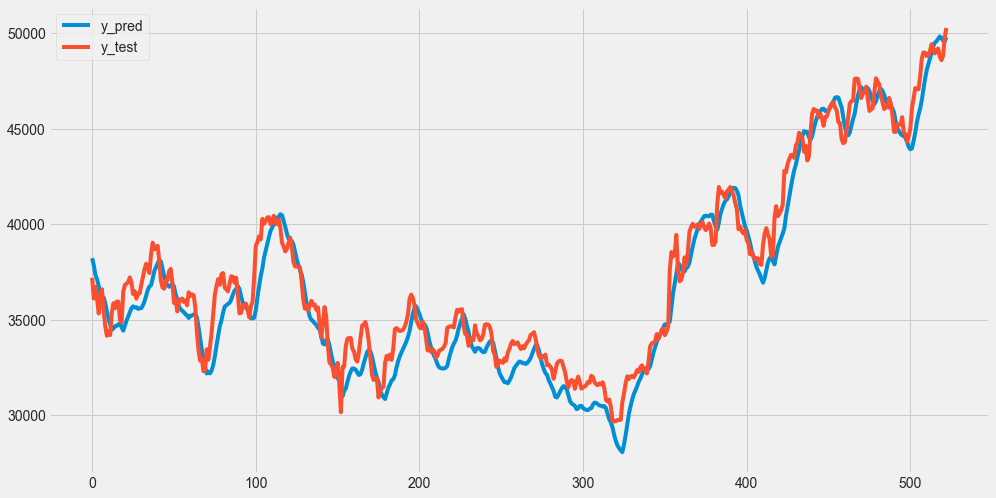

In [112]:
fig = plt.figure(figsize=(15, 8))

plt.plot(predictions_unscaled, label = "y_pred")
plt.plot(y_test_unscaled, label = "y_test")
plt.legend()
plt.show()

### Test Model on Coingecko

In [51]:
import requests

In [113]:
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api

In [114]:
coingecko = get_coingecko()


In [115]:
coingecko.head()

,open,high,low,close,volume,log_open,log_high,log_low,log_close
2021-07-30 16:00:00,38805.90,39035.31,38805.90,39035.31,2.808614e+10,10.566328,10.572222,10.566328,10.572222
2021-07-30 20:00:00,39095.21,39109.09,39006.51,39109.09,3.171428e+10,10.573755,10.574110,10.571484,10.574110
2021-07-31 00:00:00,39563.84,41780.30,39563.84,41314.59,3.704354e+10,10.585671,10.640180,10.585671,10.628971
2021-07-31 04:00:00,41936.26,41964.84,41936.26,41945.63,3.809934e+10,10.643906,10.644587,10.643906,10.644130
2021-07-31 08:00:00,41863.93,41863.93,41504.13,41520.50,3.681812e+10,10.642180,10.642180,10.633548,10.633943


In [116]:
add_ema(coingecko)

rsi = computeRSI(coingecko)

stoch_rsi(rsi)

add_stoch_rsi(coingecko)

prices = coingecko["log_close"]

get_bollinger_bands(prices, rate=20)

add_bollinger(coingecko,prices)

add_vol_roc(coingecko)


,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
2021-07-30 16:00:00,38805.90,39035.31,38805.90,39035.31,2.808614e+10,10.566328,10.572222,10.566328,10.572222,10.572222,10.572222,10.572222,10.572222,10.572222,10.572222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-30 20:00:00,39095.21,39109.09,39006.51,39109.09,3.171428e+10,10.573755,10.574110,10.571484,10.574110,10.573245,10.573202,10.573213,10.573185,10.573194,10.573183,NaN,NaN,NaN,NaN,NaN,NaN,0.129179
2021-07-31 00:00:00,39563.84,41780.30,39563.84,41314.59,3.704354e+10,10.585671,10.640180,10.585671,10.628971,10.594995,10.593239,10.593687,10.592529,10.592890,10.592459,NaN,NaN,NaN,NaN,NaN,NaN,0.168040
2021-07-31 04:00:00,41936.26,41964.84,41936.26,41945.63,3.809934e+10,10.643906,10.644587,10.643906,10.644130,10.610505,10.607466,10.608249,10.606213,10.606852,10.606090,NaN,NaN,NaN,NaN,NaN,NaN,0.028502
2021-07-31 08:00:00,41863.93,41863.93,41504.13,41520.50,3.681812e+10,10.642180,10.642180,10.633548,10.633943,10.616873,10.613606,10.614464,10.612211,10.612926,10.612073,NaN,NaN,NaN,NaN,NaN,NaN,-0.033629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-28 20:00:00,48804.79,49055.93,48804.79,48926.73,2.898285e+10,10.795584,10.800716,10.795584,10.798079,10.789151,10.786069,10.786819,10.780920,10.784870,10.779363,56.829149,83.140513,88.392706,10.781475,10.816470,10.746480,-0.014295
2021-08-29 00:00:00,48683.96,48996.13,48683.96,48783.28,2.816959e+10,10.793105,10.799497,10.793105,10.795143,10.790073,10.786741,10.787612,10.781478,10.785457,10.779928,55.011231,78.440945,82.760949,10.781772,10.817142,10.746402,-0.028060
2021-08-29 04:00:00,48936.54,49639.71,48803.46,48803.46,2.927247e+10,10.798280,10.812546,10.795556,10.795556,10.790917,10.787394,10.788369,10.782030,10.786035,10.780487,55.228480,80.693800,80.758420,10.781650,10.816800,10.746499,0.039152
2021-08-29 08:00:00,48346.04,48508.22,48259.33,48508.22,2.914709e+10,10.786140,10.789489,10.784344,10.789489,10.790697,10.787550,10.788475,10.782323,10.786232,10.780809,51.313314,70.315679,76.483475,10.781271,10.815882,10.746660,-0.004283


In [117]:
coingecko['4h Return'] = coingecko['close'].pct_change()
coingecko['4h Gradient'] = coingecko['close'].diff()

In [118]:
selected_features = ['close','rsi','bollinger_up','4h Return']
coingecko = coingecko[selected_features]
coingecko.tail(18)

,close,rsi,bollinger_up,4h Return
2021-08-26 16:00:00,46940.88,37.689017,10.829586,-0.003655
2021-08-26 20:00:00,47054.29,38.973037,10.826383,0.002416
2021-08-27 00:00:00,47254.51,41.266478,10.824264,0.004255
2021-08-27 04:00:00,47322.01,42.054852,10.821319,0.001428
2021-08-27 08:00:00,47163.12,40.669646,10.817549,-0.003358
2021-08-27 12:00:00,47444.05,44.166819,10.814712,0.005957
2021-08-27 16:00:00,48365.08,53.684954,10.809823,0.019413
2021-08-27 20:00:00,48402.89,54.027984,10.806721,0.000782
2021-08-28 00:00:00,49060.62,59.594379,10.808082,0.013589
2021-08-28 04:00:00,48986.02,58.730951,10.810448,-0.001521


### Test based on 1 window_size and 1 prediction (4 hours in de future) with Coingecko Data

In [119]:
X_gecko = coingecko.dropna()[-18:]

In [120]:
X_gecko.shape

(18, 4)

In [121]:
x_gecko_scaled = minmax_scaler.transform(X_gecko)

In [122]:
x_gecko_scaled_reshaped = x_gecko_scaled.reshape(1,18,4) #18 is the window size, 9 is number of features. 

In [123]:
predictions_api = model.predict(x_gecko_scaled_reshaped)

In [124]:
predictions_api

array([[0.7517108]], dtype=float32)

In [125]:
predictions_api_unscaled = predictions_api * range1 + min1 

In [126]:
predictions_api_unscaled


array([[48511.49]], dtype=float32)

### Creating X_test_gecko and y_test_gecko

In [127]:
X_test_gecko = coingecko.dropna()[-144:]

In [128]:
print(X_test_gecko.head(1))
print(X_test_gecko.tail(1))

                        close        rsi  bollinger_up  4h Return
2021-08-05 16:00:00  39028.84  48.190818     10.601704   0.025673
                        close       rsi  bollinger_up  4h Return
2021-08-29 12:00:00  48689.59  53.49681     10.815802   0.003739


In [129]:
X_test_gecko_scaled = minmax_scaler.transform(X_test_gecko)

In [130]:
X_test_gecko.shape

(144, 4)

In [131]:
#with the same window_size & horizon as the train data
window_size = 18
horizon = 1
X_test_gecko_sub = []
fake_y_test_gecko_sub = []
for k in range(len(X_test_gecko_scaled)-(window_size-1)-horizon):
    X_test_gecko_sub.append(X_test_gecko_scaled[k:k+window_size])
    fake_y_test_gecko_sub.append(X_test_gecko_scaled[k+window_size])

In [132]:
X_test_gecko_np = np.array(X_test_gecko_sub)
y_test_gecko_np = np.array(fake_y_test_gecko_sub)[:,0].reshape(-1,1)

In [133]:
print(X_test_gecko_np.shape)
print(y_test_gecko_np.shape)

(126, 18, 4)
(126, 1)


In [134]:
predictions_gecko = model.predict(X_test_gecko_np)

In [135]:
predictions_gecko_unscaled = predictions_gecko * range1 + min1

In [136]:
predictions_gecko_unscaled

array([[44333.664],
       [44369.83 ],
       [44321.492],
       [44445.363],
       [44249.594],
       [44164.39 ],
       [44568.434],
       [44827.26 ],
       [45249.7  ],
       [45510.93 ],
       [45715.84 ],
       [45757.89 ],
       [45765.17 ],
       [45718.773],
       [45691.49 ],
       [45728.727],
       [45689.867],
       [45870.57 ],
       [46006.08 ],
       [46270.406],
       [46388.1  ],
       [46291.3  ],
       [46337.55 ],
       [46051.62 ],
       [45889.844],
       [45374.094],
       [45084.33 ],
       [44681.465],
       [44774.82 ],
       [44920.543],
       [45176.75 ],
       [45433.355],
       [45655.477],
       [46096.01 ],
       [46424.156],
       [46706.902],
       [46544.95 ],
       [46601.273],
       [46589.023],
       [46637.34 ],
       [46776.2  ],
       [46672.18 ],
       [46452.566],
       [46291.426],
       [46250.41 ],
       [46474.05 ],
       [46810.316],
       [46932.9  ],
       [47035.72 ],
       [46769.043],


In [137]:
y_test_gecko_unscaled = y_test_gecko_np * range1 + min1

In [138]:
np.mean(np.abs(y_test_gecko_unscaled - predictions_gecko_unscaled))

722.6749627976193

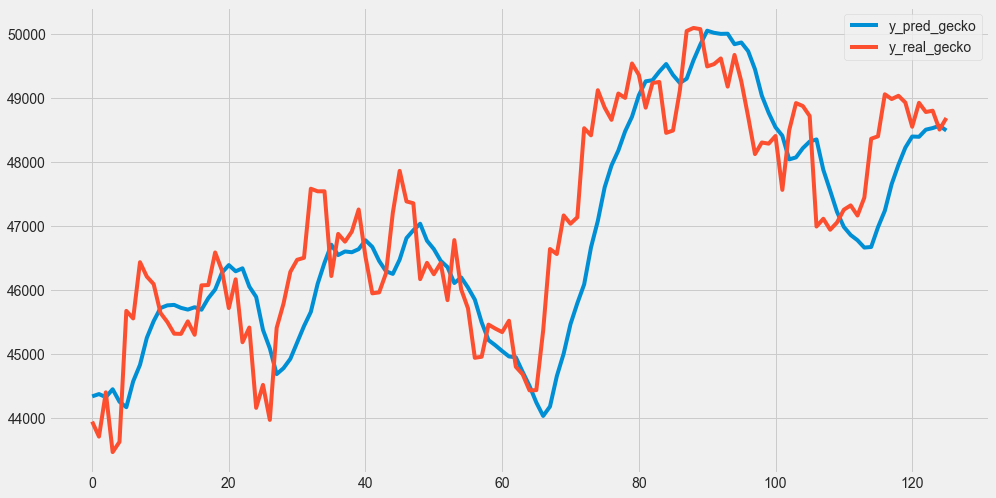

In [139]:
fig = plt.figure(figsize=(15, 8))
plt.plot(predictions_gecko_unscaled, label = "y_pred_gecko")
plt.plot(y_test_gecko_unscaled, label = "y_real_gecko")
plt.legend()
plt.show()

## Second round

In [79]:
stop stop stop 

SyntaxError: invalid syntax (3305230722.py, line 1)

In [ ]:
dataset = data[["close"]].values
dataset

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

In [ ]:
length = 60
horizon  = 1

training_split = 0.85
training_data_length = int(np.ceil(len(dataset) * training_split))
training_data_length

In [ ]:
# Create the training data set 
# Create the scaled training data set

train_data = scaled_data[0:int(training_data_length), :]
# Split the data into x_train and y_train data sets
y_train = []

x_train = [train_data[i-length:i, 0] for i in range(length, len(train_data))]
y_train = [train_data[i, 0] for i in range(length, len(train_data))]
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 543 to 2002 
test_data = scaled_data[training_data_length - length: , :]
# Create the data sets x_test and y_test

y_test = dataset[training_data_length:, :]
x_test = [test_data[i-length:i, 0] for i in range(length, len(test_data))]
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = my_mae)

# Train the model
history = model.fit(x_train, y_train, batch_size=8, epochs=5, validation_split = 0.4)

In [ ]:
plot_loss_mae(history)

In [ ]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions[:3]

In [ ]:
y_test.shape, predictions.shape

In [ ]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
# Plot the data
train = selected_data[:training_data_length]
valid = selected_data[training_data_length:].copy()

In [ ]:
train

In [ ]:
valid

In [ ]:
valid["Predictions"] = predictions
valid

In [ ]:
valid.index = pd.to_datetime(valid.index, format = "%Y-%m-%d %H:%M:%S")
train.index = pd.to_datetime(train.index, format = "%Y-%m-%d %H:%M:%S")

In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.xlim([datetime.date(2020, 1, 1), datetime.datetime.now()])
plt.show()